# PIMA Indians Diabetes Data Analyzed Using KNN

In this notebook I will be using the K Nearest Neighbors algorithm to predict whether participants from the PIMA Indians Diabetes Dataset are likely to have diabetes or not. The dataset and information on the problem on Kaggle can be found [here](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database).


## Dataset Details

The CSV file ‘diabetes.csv’ contains data from the National Institute of Diabetes and Digestive and Kidney Diseases. The features consist of various medical predictors that are typically used to indicate health conditions. The goal in this experiement is to use this data to train a KNN algorithm to predict whether a patient has diabetes or not. Note that the dataset only contains female individuals who are at least 21 years old and of Pima Indian heritage.

The file contains 768 rows of information with each row containing 8 features and a binary outcome value. To give an idea of what the CSV file looks like, here is a printout of the first 5 lines of the CSV file.


In [1]:
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import copy
import time
import seaborn

plt.style.use('ggplot')

#time total wallclock
wallclockStart = time.perf_counter()

fname = 'KNNPima/diabetes.csv'

#Load the dataset for visualization using matplotlib and pandas
data = pd.read_csv(fname)
#Print the first 5 rows of the dataframe.
print('First 5 rows of the dataframe')
print(data.head())

First 5 rows of the dataframe
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  



I have also included some general statistics about the data such as mean, standard deviation, minimum and maximum values, and 25th 50th and 75th percentiles in a table.


In [2]:
# observer shape
print('(rows by collumns): ', end='')
print(data.shape)
print(data.describe().T)
numrows = data.shape[0]

(rows by collumns): (768, 9)
                          count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.00


Below is a set of histograms where each graph represents a distribution of data for a particular feature (for a total of 9 features)


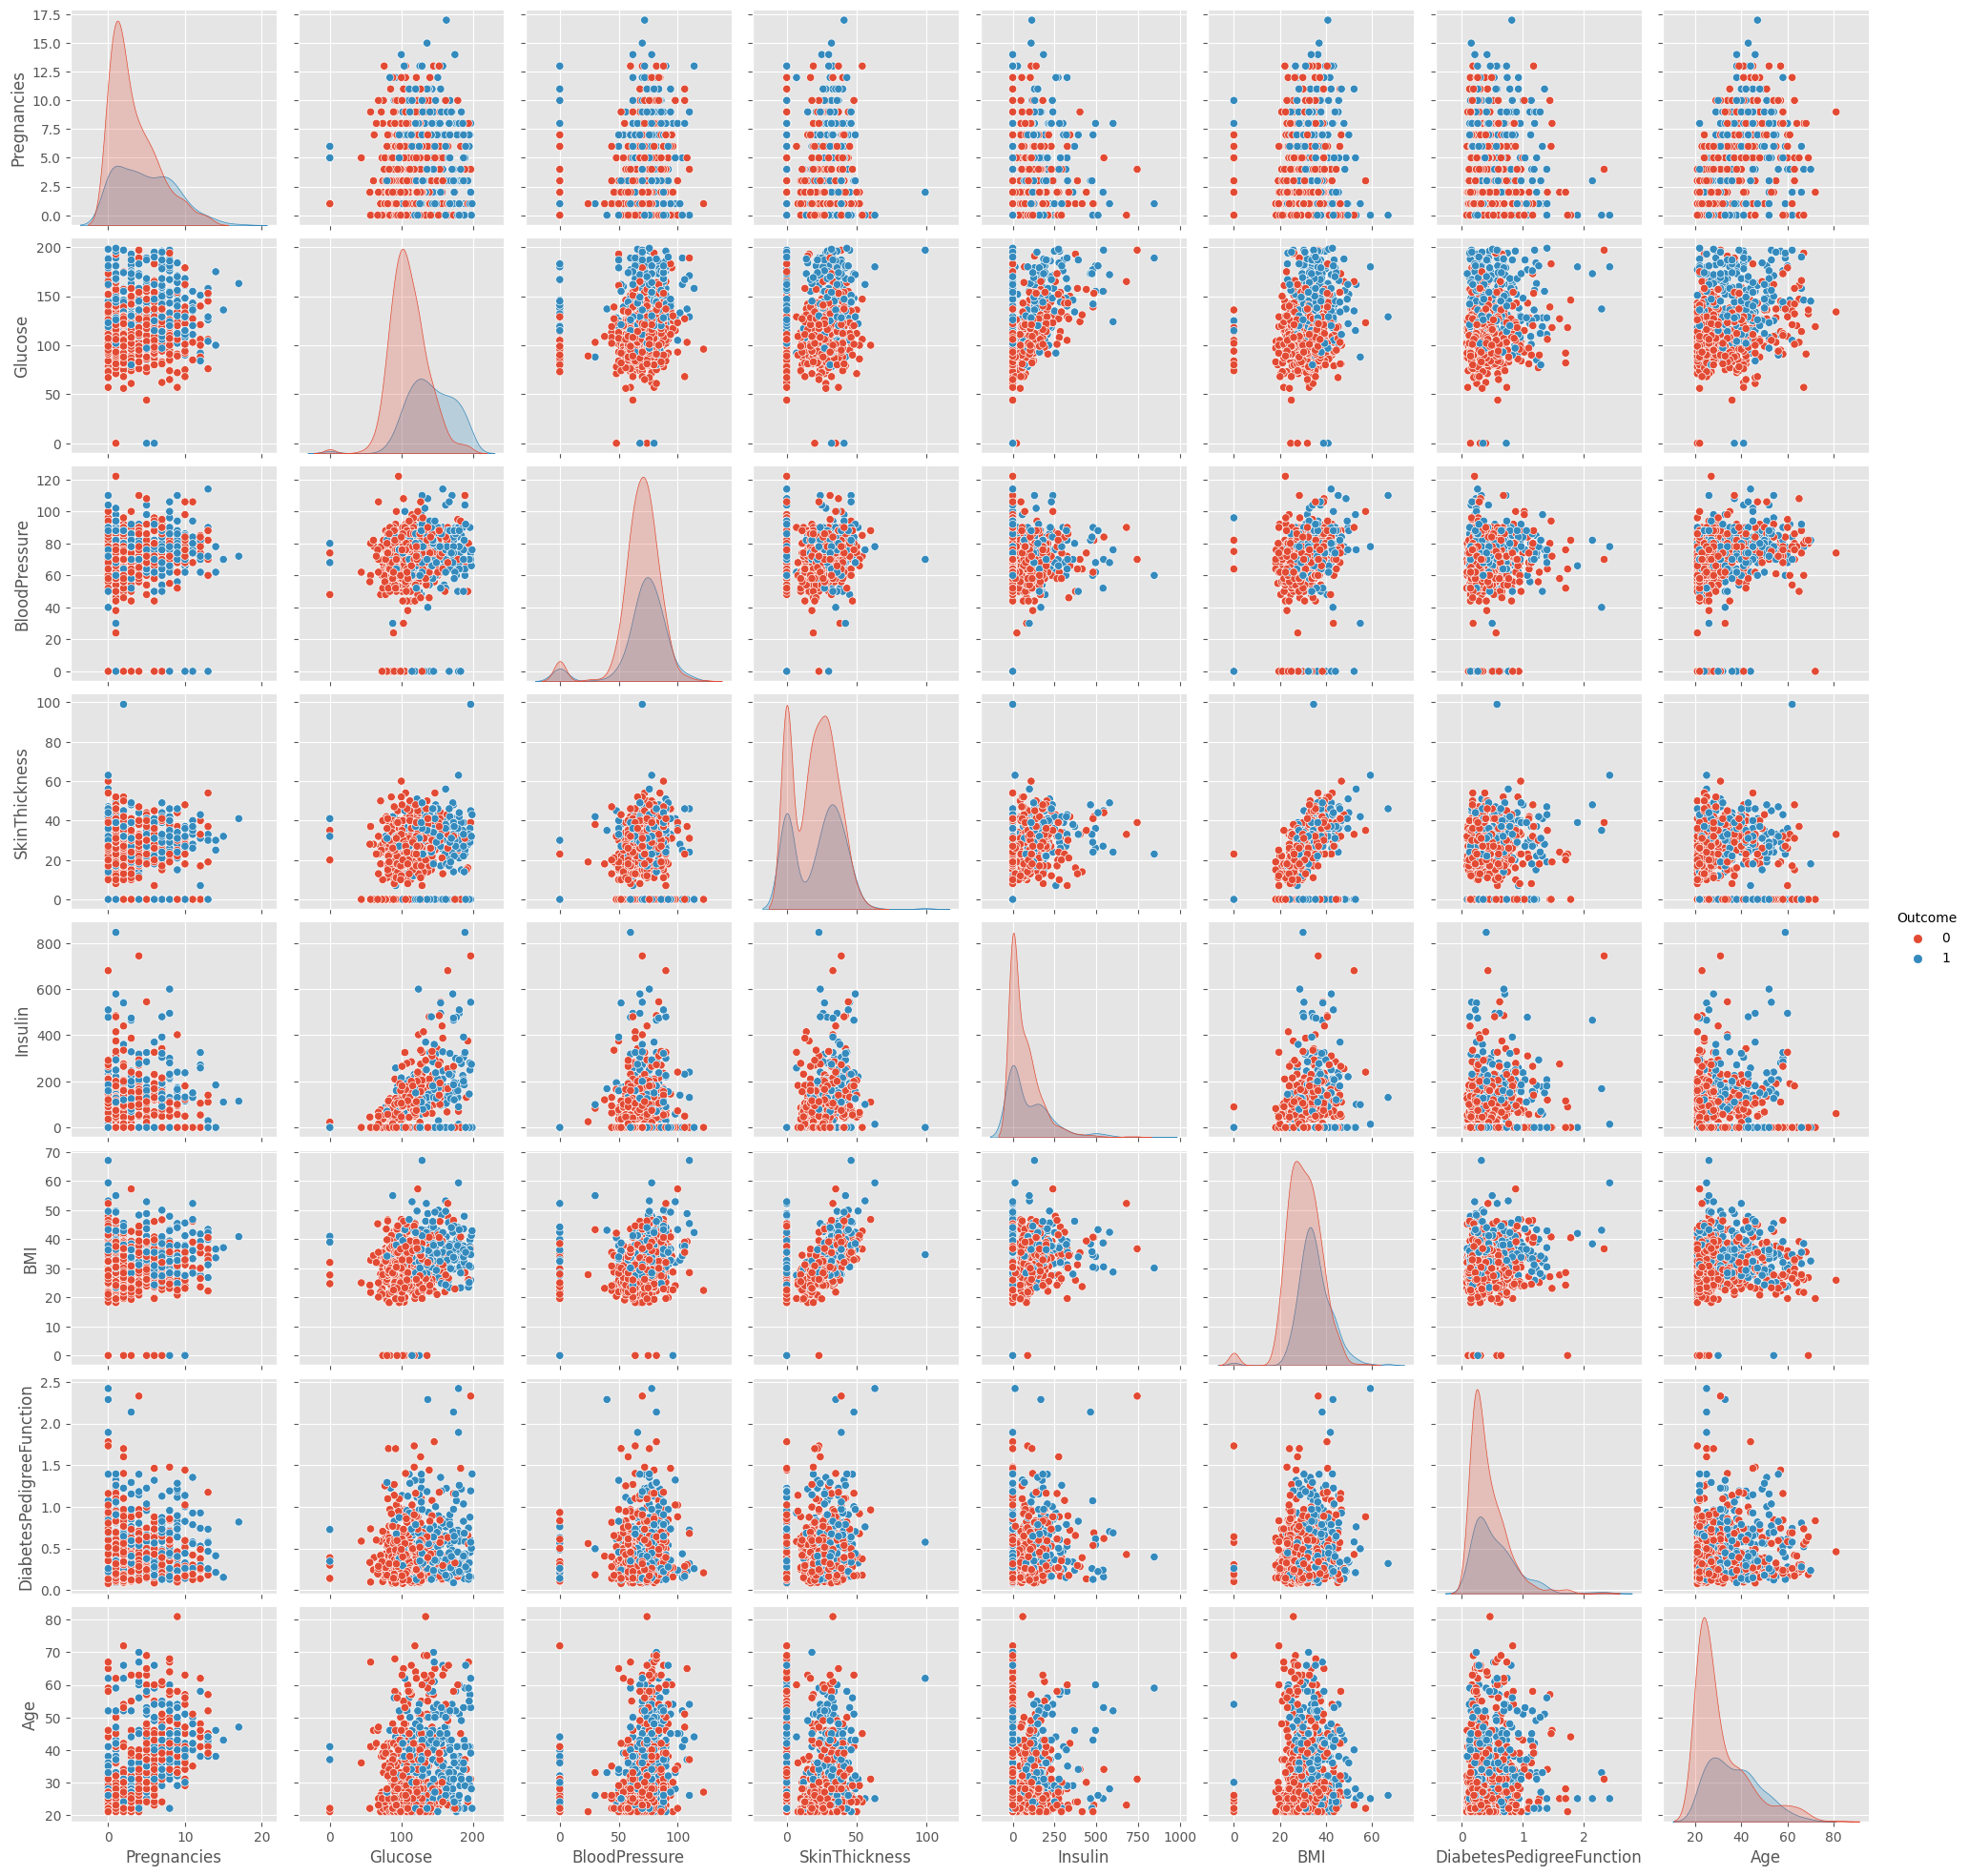

In [3]:
# data.hist(figsize = (20,20))
seaborn.pairplot(data, hue='Outcome')
plt.show()



To split the data into training and test data, I randomly selected 10 percent of the total data and removed it from the data set to be a separate test set. This is because (as discussed in class) the ideal split is 80 percent of your data for training, 10 percent for validation, and the last 10 percent for holdout.  To split the training data into a training and validation set, I used an n folds cross validation method also known as LOOCV (Leave-One-Out Cross-Validation). I used this method because it is applicable when you have a small dataset,  This is a method that splits the data into n equal sized “folds” and uses n-1 of the folds to train the data and then uses the last fold to validate the algorithm. This procedure is performed n times, where each time a different fold is used as the validation data, so the reported performance is the average of all n different iterations. I chose to partition the data into 9 total folds because this results in each validation fold being one tenth of the total original data (keeping the 90%, 10%, 10% split).


## Algorithm Description

For this dataset, I first read in the CSV file using pandas and retrieved some basic information about the dataset, as shown in the above section. As mentioned above, to perform the training and validation on the dataset, I used an n folds technique. The actual knn part of the algorithm is performed by appending the distances to all points into a list, sorting by distance, and returning the first n elements of the list. I gave three options for calculating the distance between points: Manhattan distance, Euclidean distance, and Chebyshev distance. All three of these methods are forms of the Minkowski metric, where: $$distance(x1,x2,p)=(\sum_{k=1}^{len}abs(x1_{k}-x2_{k})^{p})^{1/p}$$ When $p=1$ we are using manhattan distance, $p=2$ we are using euclidean distance, and when $p\rightarrow\infty$ we are using chebyshev distance.



In [4]:
# calulate distance
# 0 for chebyshev, 1 for manhattan, 2 for euclidean
def distance(row1, row2, distType):
	if(distType == 0):
		distance = list()
		# calculates the minkowski metric using chebyshev distance
		for i in range(len(row1)-1):
			# print(row1[i])
			# print(row2[i])
			distance.append(abs(row1[i] - row2[i]))

		return max(distance)
	elif(distType == 1):
		distance = 0.0
		# calculates the minkowski metric using manhattan distance
		for i in range(len(row1)-1):
			# print(row1[i])
			# print(row2[i])
			distance += abs(row1[i] - row2[i])

		return distance
	elif (distType == 2):
		distance = 0.0
		# calculates the minkowski metric using euclidean distance
		for i in range(len(row1)-1):
			# print(row1[i])
			# print(row2[i])
			distance += (row1[i] - row2[i])**2

		return sqrt(distance)

In [5]:
# retreive the k nearest neighbors to the test row
def getKNN(train, testRow, k, distType):
	# list to store distances on k nearby neighbors
	distances = list()
	# calculate distance to n neighbors from the test_row
	for trainRow in train:
		dist = distance(testRow, trainRow, distType)
		# appends a tuple containing 2 elements one for the row and one for the distance
		distances.append((trainRow, dist))
	# sorts the list based on the second index of 
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(k):
		neighbors.append(distances[i][0])
	return neighbors

In [6]:
def predicted_class(trainingData, testRow, k, distType):
	# gets the nearest k neighbors to the current point
	neighbors = getKNN(trainingData, testRow, k, distType)
	# create a list containing labels of the k nearest neighbors
	nearestLabels = [row2[-1] for row2 in neighbors]
	# assign label to the current test point based on what label is in the majority
	return max(set(nearestLabels), key=nearestLabels.count)

In [7]:
# kNN Algorithm
def k_nearest_neighbors(trainingData, testData, k, distType):
    # create a list to store the predicted values 
	predictions = []
    # for each node in the test data predict the outcome based
    # on the surrounding neighbors labels
	for row in testData:
		predictions.append(predicted_class(trainingData, row, k, distType))
    
	return(predictions)

In [8]:
# Calculate how accurate the trained algorithm is
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [9]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, n_folds, k, distType):
    # separate out the dataset into n_folds number of lists 
	folds = []
	dataset_copy = list(dataset)
    #  calculate the size of each fold using the dataset size and the number of folds
	fold_size = int(len(dataset) / n_folds)
    # separate the dataset into n equal folds
	for _ in range(n_folds):
		fold = []
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		folds.append(fold)
    # list to store accuracy of each fold
	scores = []
    # for every fold in the split, perform training on n_folds-1 folds and then
    # use the last fold for validation
	for fold in folds:
		train_set = list(folds)
        # remove fold for validation
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
        #  list of actual outcomes used to report accuracy
		actual = []
        # copy all data from the removed fold to the test data
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
            # add real outcome for current row to actual
			actual.append(row[-1])
            # sets the outcome value to none
			row_copy[-1] = None
         
		# returns list of predicted values for the outcomes of each row
		predicted = k_nearest_neighbors(train_set, test_set, k, distType)

        # calculate accuracy of the 
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

In [10]:
def test_with_distance_type(diabetesData, testSet, distType):
	tablerow = list()
	# evaluate algorithm
	nFolds = 9
	kNumNeighbors = 5 
	# returns list of predicted values for the outcomes of each row
	scores = evaluate_algorithm(diabetesData, nFolds, kNumNeighbors, distType)

	if(extraInfo): print('List of Scores: ', scores)
	tot = (sum(scores)/float(len(scores)))
	if(extraInfo): print('Average Accuracy: ', tot)
	tablerow.append(tot)

	totalcorrect=0
	falseP = 0
	falseN = 0
	trueP = 0
	trueN = 0
	totaliterations=len(testSet)
	correctOutcome=0
	# my accuracy calculation
	for i in range(len(testSet)):
		# select random row from dataset
		rowIndex = randrange(len(testSet))
		row = copy.deepcopy(testSet[rowIndex])
		correctOutcome=row[8]
		del row[8]
		label = predicted_class(testSet, row, kNumNeighbors, distType)
		if (label == correctOutcome): 
			totalcorrect+=1
			if (label == 1):
				trueP+=1
			else:
				trueN+=1
		else:
			if (label == 1):
				falseP+=1
			else:
				falseN+=1

	if(extraInfo):
		print("percentage correct for test set size of %s is %s" % (totaliterations, (totalcorrect/totaliterations)*100))
		print("False Negatives: ",falseN)
		print("False Positives: ",falseP)
		print("True Negatives:  ",trueN)
		print("True Positives:  ",trueP)
	tablerow.append((totalcorrect/totaliterations)*100)
	tablerow.append(falseN)
	tablerow.append(falseP)
	tablerow.append(trueN)
	tablerow.append(trueP)

	return tablerow

In [11]:
# toggle for extra tables and info
extraInfo = False
listOfTables = list()
for distType in range(3):
	accuracytable=list()
	for seednum in range(1,11):
		tablerow=list()
		tablerow.append(seednum)

		seed(seednum)

        # turn pandas dataframe into a list of lists
		diabetesData = data.values.tolist()

        # remove rows for test set
		testSize = int(0.1*numrows)
		testSet = list()

		for i in range (testSize):
			# select random row from dataset
			rowIndex = randrange(len(diabetesData))
            # remove from training data and add to test data (holdout)
			row = diabetesData.pop(rowIndex)
			testSet.append(row)
            
		tablerow.extend(test_with_distance_type(diabetesData, testSet, distType))
		accuracytable.append(tablerow)
	averages = copy.deepcopy(accuracytable[0])

	averages[0]=("Mean Value:")
	for value in range(1,len(averages)):
		averages[value]=0
	for row in range(len(accuracytable)):
		for value in range(1,len(accuracytable[row])):
			averages[value]+=float(accuracytable[row][value])



	for value in range(1,len(averages)):
		averages[value]= averages[value]/len(accuracytable)
	accuracytable.append(averages)
    
	listOfTables.append(accuracytable)

## Algorithm Results:

To measure the accuracy of my algorithm I ran it multiple times for each distance metric. The code is seeded at the very start using the seed(i) method (where i is the seed number) so that each trial is repeatable but unique. I will be reporting multiple accuracy metrics per trial. The first is the validation accuracy. The validation accuracy is calculated during the training and validation when using the n folds technique. For each iteration of the loop (where each iteration uses a different fold as the validation set) the accuracy of the classification algorithm on the validation set is recorded. Then after all the iterations, the scores for each validation fold are averaged over the number of folds to calculate the mean validation accuracy. The second accuracy metric reported will be the raw accuracy of the accuracy on the test set (which is separate from the training and validation set). This is simply calculated by going through all rows of the test set, counting how many labels are predicted correctly, and then getting the ratio num_correct/num_total. Third, alongside the raw test set accuracy, the number of false positives, false negatives, true positives, and true negative are reported as well for the test set. Below are tables detailing these statistics for each distance metric (using 9 folds, k = 5)



In [12]:
from tabulate import tabulate
#time total wallclock
wallclockEnd = time.perf_counter()
for i in range(len(listOfTables)):
	print()
	if(i == 0):
		print("\nTesting with Chebyshev distance:\n")
	elif(i == 1):
		print("\nTesting with Manhattan distance:\n")
	elif(i == 2):
		print("\nTesting with Euclidean distance:\n")
	print (tabulate(listOfTables[i], headers=["Seed\nNumber", "Validation\nAccuracy", "Test\nAccuracy", "False\nNegatives", "False\nPositives", "True\nNegatives", "True\nPositives"]))
	print()



Testing with Chebyshev distance:

Seed           Validation        Test        False        False         True         True
Number           Accuracy    Accuracy    Negatives    Positives    Negatives    Positives
-----------  ------------  ----------  -----------  -----------  -----------  -----------
1                 70.4678     72.3684         13            8           35           20
2                 66.9591     80.2632         12            3           49           12
3                 71.1988     82.8947          7            6           43           20
4                 69.4444     73.6842         17            3           44           12
5                 71.1988     75              10            9           46           11
6                 69.7368     86.8421          5            5           39           27
7                 71.6374     90.7895          4            3           51           18
8                 71.6374     69.7368         16            7           46    

As you can see from the previous three tables, the three versions of the Minkowski metric I used to measure distance performed similarly. Manhattan and Euclidean distances performed within ~1% of each other in both validation and test accuracy, with Manhattan performing slightly better. Chebyshev distance also performed similarly; however, its test accuracy was lower than Manhattan (best performing metric) by ~4%. From this information, I can conclude that the best metric to use on this data is Manhattan distance, but the results are all so similar that any of the three distance metrics would be viable options.

## Runtime:
The runtime of this algorithm is fairly large since I chose to use an n folds technique. I thought this was fair considering the dataset is very small with relatively low dimensionality (<1000 entries, 8 features). The average runtime for the knn algorithm that performs the k nearest neighbors calculation (k_nearest_neighbors) is 0.172 seconds per run. The O(n) efficiency of this method is $O(\frac{n}{10}*\frac{8n}{10}*f)=O(\frac{2fn^{2}}{25})=O(fn^{2})$ where n is the total dataset size and f is the feature size (dimenionality). This is because this method can be broken down into an outer for-loop that runs for 1/10 of the dataset size, a middle for loop that runs for 8/10 of the dataset size, and one inner for loop that runs for the feature size. This calculation does not factor in the n folds technique, as that is performed outside of this function call. The method that performs the whole training and evaluation phase (evaluate_algorithm) uses the n folds technique. The average runtime for the evaluate_algorithm method is 1.347 seconds per run, and the Big-O efficiency is also $O(fn^{2})$ which makes sense considering k_nearest_neighbors is called n times after splitting the folds (where n is the number of folds) and we are using n=9, which is a constant so it is dropped. As for the total wall clock time for this whole notebook, it is output in the below cell:

In [13]:
ms = (wallclockEnd-wallclockStart)
print("exec_time for jupyter notebook is ",ms," secs.")

exec_time for jupyter notebook is  47.821606648999996  secs.


## References
https://scikit-learn.org/stable/modules/cross_validation.html 

https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

https://stats.stackexchange.com/questions/353904/do-i-need-data-separation-in-knn

https://www.educba.com/python-print-table/

https://medium.com/@kunal_gohrani/different-types-of-distance-metrics-used-in-machine-learning-e9928c5e26c7

https://becominghuman.ai/machine-learning-series-day-4-k-nn-8e9ba757a419

https://pynative.com/python-get-execution-time-of-program/#example-get-program-s-execution-time-in-seconds

https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix

https://www.tutorialspoint.com/how-to-show-numpy-2d-array-as-grayscale-image-in-jupyter-notebook